Conjunto de Dados

https://zenodo.org/record/1188976

In [1]:
# Imports
import joblib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display
import seaborn as sns
import xgboost
import sklearn
from glob import glob
from joblib import load
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:

diretorio = 'dados'
# Dicionários para receber os resultados do loop
arquivos = {}
taxa_amostragem = {}

# Loop pelo diretório com os arquivos de áudio
for itens in range(1,25):
    if len(str(itens)) == 1:
        audio_dir = diretorio + '/Actor_' + str('0') + str(itens)
    else:
        audio_dir = diretorio + '/Actor_' + str(itens)
    
    # Armazena o caminho para todos os arquivos de um diretório
    audio_files = glob(audio_dir + '/*.wav')
        
    # Armazena o caminho e a taxa de amostragem de cada arquivo na pasta
    for i in range(len(audio_files)):
        x = audio_files[i]
        audio, sfreq = lr.load(audio_files[i], sr = None)
        arquivos[x] = len(audio) / sfreq
        taxa_amostragem[x] = sfreq

In [3]:
# Obtém as taxas de amostragem dos arquivos
[taxa_amostragem[i] for i in list(taxa_amostragem.keys())[:10]]

[48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000]

In [4]:
# Verifica se todas as taxas de amostragem são iguais
all(value == 48000 for value in taxa_amostragem.values())

True

In [5]:
# Cria um dataframe para receber a lista de caminhos dos arquivos
arquivos_audio = pd.DataFrame()

In [6]:
# Carrega o dataframe
for keys, values in arquivos.items():
    arquivos_audio.at[keys,'lengthoffile'] = values   

In [7]:
# Visualiza os dados
arquivos_audio.head()

,lengthoffile
dados/Actor_01/03-02-06-01-02-02-01.wav,4.437771
dados/Actor_01/03-02-01-01-01-01-01.wav,4.237583
dados/Actor_01/03-02-05-01-01-01-01.wav,4.371021
dados/Actor_01/03-02-05-01-01-02-01.wav,4.771438
dados/Actor_01/03-02-03-01-02-01-01.wav,4.337667


In [8]:
# Cria uma função para retornar os arquivos de áudio e a taxa de amostragem de cada arquivo
def extrai_audio_data(file):
    audio, sfreq = lr.load(file, sr = None)
    return audio, sfreq

In [9]:
# Vamos verificar o shape dos arquivos de áudio e taxa de amostragem
audio, sfreq = extrai_audio_data(arquivos_audio.index[0])
print(f'\nShape da Série Representando o Áudio (y): {audio.shape} \nTaxa de Amostragem (sr): {sfreq}')


Shape da Série Representando o Áudio (y): (213013,) 
Taxa de Amostragem (sr): 48000


In [10]:
# Cria uma função para extrair o MFCC de um dado arquivo
def mfcc_extract(file):
    audio, sfreq = extrai_audio_data(file)
    mfccs = librosa.feature.mfcc(audio, sr = sfreq)
    return mfccs

In [11]:
# Cria uma lista vazia
list_data_frame = []

In [12]:
# Considere o arquivo: '03-01-06-01-02-01-12.wav'

# Esse arquivo é:

# Somente áudio(03) 
# Discurso(01) 
# Medo(06) 
# Intensidade normal(01) 
# Declaração "cães"(02) 
# 1ª repetição(01) 
# 12º ator(12) Mulher.

# Vamos fazer um loop e extrair os detalhes acima de todos os arquivos.

# Loop por cada arquivo
for file_path in arquivos_audio.index:
    
    # Chamamos a função de extração mfcc para retornar coeficientes e dados mfcc
    data = mfcc_extract(file_path)
    
    # Transformamos os dados no formato (n samples, n features)
    frame = pd.DataFrame(data.T, columns = ['mfcc' + str(x) for x in range(0,20)])

    
    # Extraímos gênero do ator do arquivo usando o encoding
    frame['ID_ATOR_SEXO'] = file_path[33:35]
    
    # Extraímos o código da emoção do arquivo usando o encoding
    frame['ID_EMOCAO'] = file_path[21:23]
    
    # Extraímos a intensidade da emoção do arquivo usando o encoding
    frame['ID_INTENSIDADE_EMOCIONAL'] = file_path[24:26]    
    
    # Inclui na lista
    list_data_frame.append(frame)

In [13]:
# Concatena os elementos da lista em um dataframe
df_dados_audio = pd.concat(list_data_frame, ignore_index = True)

In [14]:
# O dataset está quase pronto. 
# Precisamos apenas incluir os labels para compreender o que temos em cada arquivo de áudio.
df_dados_audio.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,ID_ATOR_SEXO,ID_EMOCAO,ID_INTENSIDADE_EMOCIONAL
0,-736.889404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,01,06,01
1,-736.889404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,01,06,01
2,-736.889404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,01,06,01
3,-735.132080,2.316768,1.849498,1.178376,0.412101,-0.361496,-1.079493,-1.683317,-2.101268,-2.258119,...,-0.346293,0.321060,0.885656,1.314950,1.584855,1.662810,1.519631,01,06,01
4,-736.397583,0.652058,0.527373,0.337825,0.108193,-0.131628,-0.350683,-0.521074,-0.621674,-0.640843,...,-0.043789,0.165749,0.344082,0.468152,0.522754,0.502827,0.413638,01,06,01


In [15]:
# Define o label para o gênero da voz a partir do código de gênero, sendo ímpar para masculino e par para feminino
df_dados_audio["LABEL_GENERO"] = list(map(lambda x: 'homem' if int(x)%2 == 1 else 'mulher',
                                          df_dados_audio.ID_ATOR_SEXO))

In [16]:
# Label para a emoção
df_dados_audio['LABEL_EMOCAO'] = df_dados_audio.ID_EMOCAO.map({'01':'neutro',
                                                               '02':'calmo',
                                                               '03':'feliz',
                                                               '04':'triste',
                                                               '05':'zangado',
                                                               '06':'medo',
                                                               '07':'nojo',
                                                               '08':'surpreso'})

In [17]:
# Intensidade emocional normal ou forte 
df_dados_audio['LABEL_INTENSIDADE'] = df_dados_audio.ID_INTENSIDADE_EMOCIONAL.map({'01':'normal',
                                                                                   '02':'forte'})

In [18]:
# Gênero e emoção da voz no áudio
df_dados_audio['LABEL_GENERO_EMOCAO'] = df_dados_audio['LABEL_GENERO'] + "_" + df_dados_audio['LABEL_EMOCAO']
df_final = df_dados_audio

In [19]:
# Shape
df_final.shape

(441586, 27)

In [20]:
# Tipos de Dados
df_final.dtypes

mfcc0                       float32
mfcc1                       float32
mfcc2                       float32
mfcc3                       float32
mfcc4                       float32
mfcc5                       float32
mfcc6                       float32
mfcc7                       float32
mfcc8                       float32
mfcc9                       float32
mfcc10                      float32
mfcc11                      float32
mfcc12                      float32
mfcc13                      float32
mfcc14                      float32
mfcc15                      float32
mfcc16                      float32
mfcc17                      float32
mfcc18                      float32
mfcc19                      float32
ID_ATOR_SEXO                 object
ID_EMOCAO                    object
ID_INTENSIDADE_EMOCIONAL     object
LABEL_GENERO                 object
LABEL_EMOCAO                 object
LABEL_INTENSIDADE            object
LABEL_GENERO_EMOCAO          object
dtype: object

In [21]:
# Visualizando os dados
df_final.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc17,mfcc18,mfcc19,ID_ATOR_SEXO,ID_EMOCAO,ID_INTENSIDADE_EMOCIONAL,LABEL_GENERO,LABEL_EMOCAO,LABEL_INTENSIDADE,LABEL_GENERO_EMOCAO
0,-736.889404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,01,06,01,homem,medo,normal,homem_medo
1,-736.889404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,01,06,01,homem,medo,normal,homem_medo
2,-736.889404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,01,06,01,homem,medo,normal,homem_medo
3,-735.132080,2.316768,1.849498,1.178376,0.412101,-0.361496,-1.079493,-1.683317,-2.101268,-2.258119,...,1.584855,1.662810,1.519631,01,06,01,homem,medo,normal,homem_medo
4,-736.397583,0.652058,0.527373,0.337825,0.108193,-0.131628,-0.350683,-0.521074,-0.621674,-0.640843,...,0.522754,0.502827,0.413638,01,06,01,homem,medo,normal,homem_medo


## Análise Exploratória

<AxesSubplot:xlabel='LABEL_GENERO', ylabel='count'>

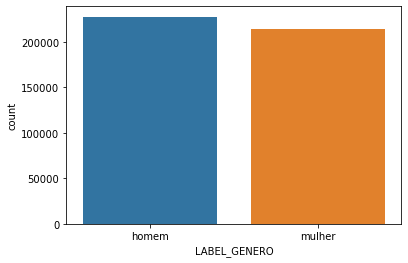

In [22]:
# Verificando a distribuição de arquivos de áudio por gênero do ator
sns.countplot(x = 'LABEL_GENERO', data = df_final)

<AxesSubplot:xlabel='LABEL_EMOCAO', ylabel='count'>

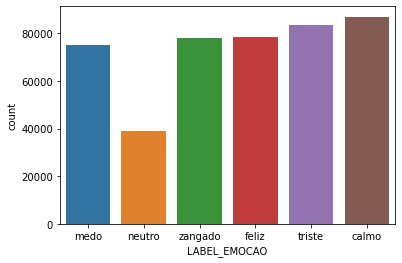

In [23]:
# Verificando a distribuição de arquivos de áudio por emoção do ator
sns.countplot(x = 'LABEL_EMOCAO', data = df_final)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'homem_medo'),
  Text(1, 0, 'homem_neutro'),
  Text(2, 0, 'homem_zangado'),
  Text(3, 0, 'homem_feliz'),
  Text(4, 0, 'homem_triste'),
  Text(5, 0, 'homem_calmo'),
  Text(6, 0, 'mulher_medo'),
  Text(7, 0, 'mulher_triste'),
  Text(8, 0, 'mulher_feliz'),
  Text(9, 0, 'mulher_zangado'),
  Text(10, 0, 'mulher_calmo'),
  Text(11, 0, 'mulher_neutro')])

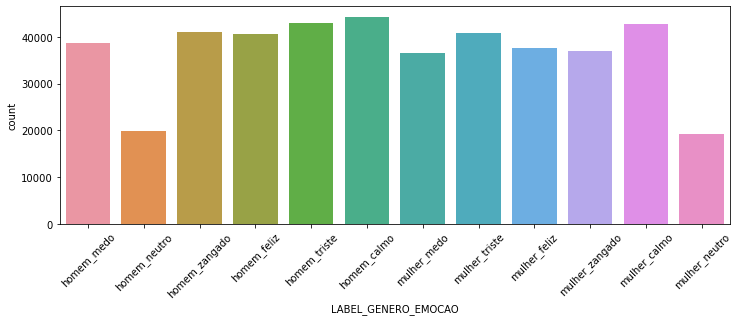

In [24]:
# Verificando a distribuição de arquivos de áudio por gênero/emoção do ator
plt.figure(figsize = (12,4))
sns.countplot(x = 'LABEL_GENERO_EMOCAO', data = df_final)
plt.xticks(rotation = 45)

## Machine Learning

### Modelo 1 - Prever o gênero do ator no áudio

In [25]:
# Gerando o valor de x (sem os labels)
X = df_final[df_final.columns[:-7]].values

In [26]:
# Aplicando Label Encoder para converter a string em representação numérica
y = LabelEncoder().fit_transform(df_final['LABEL_GENERO'])

In [27]:
# Divisão em dados de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.33, stratify = y, shuffle = True)

In [28]:
# Shape
X_treino.shape

(295862, 20)

In [29]:
# Shape
y_treino.shape

(295862,)

In [30]:
# Shape
X_teste.shape

(145724, 20)

In [31]:
# Shape
y_teste.shape

(145724,)

In [32]:
z_scaler = StandardScaler()
# Aplicamos o scaler nos dados de treino
fitted = z_scaler.fit(X_treino)

# E transformamos dados de treino e de teste
X_treino = fitted.transform(X_treino)
X_teste = fitted.transform(X_teste)

In [33]:
xgb = XGBClassifier()
print('\nIniciando o treinamento...')

xgb.fit(X_treino, y_treino)
y_pred = xgb.predict(X_teste)

acc = accuracy_score(y_teste, y_pred)
print('\nA Acurácia do Classificador é:', acc)

cm = confusion_matrix(y_teste, y_pred)
print('\nConfusion Matrix')
print(cm)


Iniciando o treinamento...
[09:03:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

A Acurácia do Classificador é: 0.9236501880266805

Confusion Matrix
[[69567  5543]
 [ 5583 65031]]


In [34]:
xgb = DecisionTreeClassifier()
print('\nIniciando o treinamento...')

xgb.fit(X_treino, y_treino)
y_pred = xgb.predict(X_teste)

acc = accuracy_score(y_teste, y_pred)
print('\nA Acurácia do Classificador é:', acc)

cm = confusion_matrix(y_teste, y_pred)
print('\nConfusion Matrix')
print(cm)


Iniciando o treinamento...

A Acurácia do Classificador é: 0.9182907414015536

Confusion Matrix
[[69180  5930]
 [ 5977 64637]]


In [35]:
xgb = RandomForestClassifier()
print('\nIniciando o treinamento...')

xgb.fit(X_treino, y_treino)
y_pred = xgb.predict(X_teste)

acc = accuracy_score(y_teste, y_pred)
print('\nA Acurácia do Classificador é:', acc)

cm = confusion_matrix(y_teste, y_pred)
print('\nConfusion Matrix')
print(cm)


Iniciando o treinamento...

A Acurácia do Classificador é: 0.9458977244654277

Confusion Matrix
[[71979  3131]
 [ 4753 65861]]


### Modelo 2 - Prever gênero e emoção do ator no áudio

In [36]:
# Gerando o valor de x (sem os labels)
X1 = df_final[df_final.columns[:-7]].values

In [37]:
# Aplicando Label Encoder para converter a string em representação numérica
y1 = LabelEncoder().fit_transform(df_final['LABEL_GENERO_EMOCAO'])

In [38]:
# Divisão em dados de treino e de teste
X1_treino, X1_teste, y1_treino, y1_teste = train_test_split(X1, y1, test_size = 0.33, stratify = y, shuffle = True)

In [39]:
# Shape
X1_treino.shape

(295862, 20)

In [40]:
# Shape
y1_treino.shape

(295862,)

In [41]:
# Shape
X1_teste.shape

(145724, 20)

In [42]:
# Shape
y1_teste.shape

(145724,)

In [43]:
# Aplicamos o scaler nos dados de treino
fitted = z_scaler.fit(X1_treino)

# E transformamos dados de treino e de teste
X1_treino = fitted.transform(X1_treino)
X1_teste = fitted.transform(X1_teste)

In [44]:
xgb = XGBClassifier()
print('\nIniciando o treinamento...')

xgb.fit(X1_treino, y1_treino)
y_pred = xgb.predict(X1_teste)

acc = accuracy_score(y1_teste, y_pred)
print('\nA Acurácia do Classificador é:', acc)

cm = confusion_matrix(y1_teste, y_pred)
print('\nConfusion Matrix')
print(cm)


Iniciando o treinamento...
[09:05:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

A Acurácia do Classificador é: 0.581489665394856

Confusion Matrix
[[10883   670   697   318  1377   116   268    80    52    41   131    23]
 [ 1158  6781  1432   209   806  1747   235   366   292    36   123   234]
 [ 1180  1439  5807   180  1280  1849   176   173   323    42   135   126]
 [ 1834   553   468  2095  1063   106   194    26    11    47    51    11]
 [ 2691   898  1307   329  7348   652   357   237   180    81   194    32]
 [  133  1386  1256    55   252  9166    43   181   315    16   104   653]
 [  381   177   126    40   164   163  9846   521   461   343  1450   368]
 [   23   201   190     6    73   271   670  7961  1040   181   514  1278]
 [   77   180   290    24   133   584  1015  1312  

In [45]:
xgb = DecisionTreeClassifier()
print('\nIniciando o treinamento...')

xgb.fit(X1_treino, y1_treino)
y_pred = xgb.predict(X1_teste)

acc = accuracy_score(y1_teste, y_pred)
print('\nA Acurácia do Classificador é:', acc)

cm = confusion_matrix(y1_teste, y_pred)
print('\nConfusion Matrix')
print(cm)


Iniciando o treinamento...

A Acurácia do Classificador é: 0.5807554006203508

Confusion Matrix
[[9057  889  924 1047 1641  282  238   79  136   96  212   55]
 [ 849 7330 1324  490  947 1304  166  198  288   96  219  208]
 [ 949 1359 6158  500 1183 1361  178  232  288   62  209  231]
 [ 918  571  493 3011  827  203  126   41   62   65  110   32]
 [1727  992 1313  905 7893  537  188  134  213  104  207   93]
 [ 253 1348 1396  211  548 8429   85  260  339   60  208  423]
 [ 252  162  179  134  250  100 9017  579  780  759 1489  339]
 [  87  196  193   54  143  262  599 7795 1028  333  667 1051]
 [ 136  270  329   92  204  347  768 1096 6524  382 1070 1046]
 [ 112   83   92   64  100   74  729  321  416 3500  647  158]
 [ 192  198  193   79  202  196 1494  690 1141  682 7851  404]
 [  56  252  212   41   80  493  298 1106 1003  207  471 8065]]


In [46]:
xgb = RandomForestClassifier()
print('\nIniciando o treinamento...')

xgb.fit(X1_treino, y1_treino)
y_pred = xgb.predict(X1_teste)

acc = accuracy_score(y1_teste, y_pred)
print('\nA Acurácia do Classificador é:', acc)

cm = confusion_matrix(y1_teste, y_pred)
print('\nConfusion Matrix')
print(cm)


Iniciando o treinamento...

A Acurácia do Classificador é: 0.743117125524965

Confusion Matrix
[[12477   342   373   191   869    93   136    20    36    30    86     3]
 [  846  9405   895   101   567  1014   116   107   144    27   102    95]
 [  869   794  8233   142   815  1270   107   107   191    26    79    77]
 [ 1430   322   291  3380   723    88   113    13    29    23    41     6]
 [ 1629   493   745   220 10400   414   144    63    81    25    69    23]
 [  148   907   823    35   225 10738    35   127   185    29    74   234]
 [  261   104   104    53   131    79 11703   254   249   155   795   152]
 [   34   188   182    17    77   227   487  9640   546    56   292   662]
 [   84   158   244    22   133   330   666   662  8272    69   820   804]
 [   88    90    64    33    84    79   890   178   169  4015   522    84]
 [  207   191   154    31   123   194  1199   355   509   119 10054   186]
 [   19   143   156     5    28   425   196   585   503    36   215  9973]]
